## Loading Packages and Tables

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import dask.dataframe as dd
import streamlit as st

In [201]:
diag = pd.read_csv('C:\\Users\\yahya\\Documents\\GitHub\\Internship\\CSV_files\\diagnoses_table.csv', dtype={"icd_code": "object"})


In [202]:
def detect_icd_version(code):
    code = str(code).strip().upper()
    return 10 if code and code[0].isalpha() else 9

# Apply to your DataFrame
diag['icd_version'] = diag['icd_code'].apply(detect_icd_version)

In [203]:
admission = pd.read_csv('C:\\Users\\Yahya\\Documents\\GitHub\\Internship\\CSV_files\\admissions_table.csv')

In [204]:
diag_adm_table = diag.merge(admission, on=['subject_id', 'hadm_id'])
diag_adm_table = diag_adm_table.sort_values(by="subject_id")
diag_adm_table = diag_adm_table.reset_index(drop=True)

In [205]:
diag_adm_table.shape

(5071195, 6)

## Selecting CML patients

In [206]:
icd9 = diag[diag['icd_code'].str.match(r'^\d')]
filtered_icd9 = icd9[(icd9['icd_code'].astype(float) >= 20510) & (icd9['icd_code'].astype(float) <= 20512)]

In [207]:
filtered_icd9['icd_code'].value_counts()

20510    260
20511     67
20512     10
Name: icd_code, dtype: int64

In [208]:
filtered_icd9.shape

(337, 4)

In [209]:
icd10 = diag[diag['icd_code'].str.match(r'^[A-Z]')]
filtered_icd10 = icd10[icd10['icd_code'].str.startswith('C921')]
filtered_icd10['icd_code'].value_counts()

C9210    219
C9211     72
C9212      4
Name: icd_code, dtype: int64

In [210]:
filtered_icd10.shape

(295, 4)

In [211]:
diag_cml = pd.concat([filtered_icd9, filtered_icd10])
diag_cml = diag_cml.reset_index(drop=True)
diag_cml['icd_code'].value_counts()

20510    260
C9210    219
C9211     72
20511     67
20512     10
C9212      4
Name: icd_code, dtype: int64

In [212]:
diag_cml.shape

(632, 4)

In [213]:
# diag_cml.to_csv(r"C:\Users\Yahya\Documents\GitHub\Internship\CSV_files\cml_diagnoses.csv", index=False)

In [214]:
print(f"Unique patient numbers: {diag_cml['subject_id'].nunique()}")

Unique patient numbers: 240


## Selecting CVD patients

In [215]:
ICD_9_dict = {
    'hypertensive': range(401, 406),
    'ischemic': range(410, 415),
    'pulmonary': range(415, 418),
    'other': range(420, 430),
    'cerebrovascular': range(430, 439),
    'arterioles': range(440, 450)
}

In [216]:
diag_icd9 = diag[diag['icd_code'].str.match(r'^\d')]

In [217]:
diag_icd9['icd_code'] = diag_icd9['icd_code'].astype('int64')

c:\Users\Yahya\Documents\GitHub\Internship\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [218]:
condition = None

for name, icd_range in ICD_9_dict.items():
    lower = min(icd_range)
    upper = max(icd_range)
    new_condition = (diag_icd9['icd_code'] >= lower) & (diag_icd9['icd_code'] <= upper)
    
    condition = new_condition if condition is None else (condition | new_condition)

# Apply the filter
diag_cvd_9 = diag_icd9[condition]

In [219]:
def get_icd9_category(icd_code):
    try:
        major = int(str(icd_code)[:3])
        for category, code_range in ICD_9_dict.items():
            if major in code_range:
                return category
    except:
        return None

In [220]:
diag_cvd_9['cvd_category'] = diag_cvd_9['icd_code'].apply(get_icd9_category)

c:\Users\Yahya\Documents\GitHub\Internship\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [221]:
diag_cvd_9.shape

(23500, 5)

In [222]:
diag_cvd_9['icd_code'].sort_values().value_counts()

412    15201
414     1950
431     1887
413     1528
417     1231
416      795
430      737
449      105
415       63
436        3
Name: icd_code, dtype: int64

In [223]:
diag_cvd_10 = diag[diag['icd_code'].str.startswith('I')]

In [224]:
ICD_10_dict = {
    'hypertensive': ['I10', 'I11', 'I12', 'I13', 'I15'],
    'ischemic': ['I20', 'I21', 'I22', 'I23', 'I24', 'I25'],
    'pulmonary': ['I26', 'I27'],
    'other': ['I30', 'I31', 'I33', 'I34', 'I35', 'I36', 'I37', 'I38', 'I39'],
    'cerebrovascular': ['I60', 'I61', 'I62', 'I63', 'I64', 'I65', 'I66', 'I67', 'I68', 'I69'],
    'arterioles': ['I70', 'I71', 'I72', 'I73', 'I74', 'I77']
}

In [225]:
def get_icd10_category(icd_code):
    try:
        for category, prefixes in ICD_10_dict.items():
            if any(icd_code.startswith(p) for p in prefixes):
                return category
    except:
        return None

In [226]:
diag_cvd_10['cvd_category'] = diag_cvd_10['icd_code'].apply(get_icd10_category)


c:\Users\Yahya\Documents\GitHub\Internship\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [227]:
diag_cvd = pd.concat([diag_cvd_9, diag_cvd_10])
diag_cvd = diag_cvd.reset_index(drop=True)

In [228]:
diag_cvd.shape

(509603, 5)

In [229]:
diag_cvd['subject_id'].value_counts(dropna=True).unique().sum()

13378

In [230]:
diag_cvd['cvd_category'].value_counts(dropna=False)

NaN                185276
hypertensive       137400
ischemic           101714
cerebrovascular     29951
arterioles          21069
pulmonary           17201
other               16992
Name: cvd_category, dtype: int64

In [231]:
diag_cvd = diag_cvd.dropna()
diag_cvd.shape

(324327, 5)

## Merging CML and CVD tables and creating categories

In [232]:
diag_cml = diag_cml.merge(admission, on=['subject_id', 'hadm_id'])
diag_cml = diag_cml.reset_index(drop=True)
diag_cvd = diag_cvd.merge(admission, on=['subject_id', 'hadm_id'])
diag_cvd = diag_cvd.reset_index(drop=True)

In [233]:
diag_cvd.head(25)

,subject_id,hadm_id,icd_code,icd_version,cvd_category,admittime,dischtime
0,10000764,27897940,412,9,ischemic,2132-10-14 23:31:00,2132-10-19 16:30:00
1,10000980,24947999,412,9,ischemic,2190-11-06 20:57:00,2190-11-08 15:58:00
2,10000980,25242409,412,9,ischemic,2191-04-03 18:48:00,2191-04-11 16:21:00
3,10000980,26913865,412,9,ischemic,2189-06-27 07:38:00,2189-07-03 03:00:00
4,10001176,23334588,412,9,ischemic,2186-11-29 03:56:00,2186-12-02 15:00:00
5,10001877,21320596,412,9,ischemic,2150-11-21 23:02:00,2150-11-23 16:46:00
6,10001877,25679292,412,9,ischemic,2149-05-21 15:53:00,2149-05-27 13:35:00
7,10002013,21975601,412,9,ischemic,2159-12-14 23:55:00,2159-12-17 14:04:00
8,10002013,23581541,412,9,ischemic,2160-05-18 07:45:00,2160-05-23 13:30:00
9,10002013,23745275,412,9,ischemic,2157-10-31 12:54:00,2157-11-01 13:00:00


In [234]:
# Keep only columns we need
cml = diag_cml[['subject_id', 'admittime']].rename(columns={'admittime': 'cml_date'})
cvd = diag_cvd[['subject_id', 'admittime']].rename(columns={'admittime': 'cvd_date'})


In [235]:
cml['cml_date'] = pd.to_datetime(cml['cml_date'])
cvd['cvd_date'] = pd.to_datetime(cvd['cvd_date'])

In [236]:
cml['subject_id'].nunique()

240

In [237]:
cml_cvd = cml.merge(cvd, on='subject_id', how='left')
cml_cvd = cml_cvd.reset_index(drop=True)

In [238]:
### check if all CML patients are in the merged table
cml[cml['subject_id'].isin(cml_cvd['subject_id'].unique())]['subject_id'].nunique()

240

In [239]:
cml_cvd['has_future_cvd'] = (cml_cvd['cvd_date'] > cml_cvd['cml_date']).astype(int) ### what if the patient got CML and CVD in one admission
cml_cvd['has_immediate_cvd'] = (cml_cvd['cvd_date'] == cml_cvd['cml_date']).astype(int)
cml_cvd['has_cvd'] = (cml_cvd['cvd_date'] >= cml_cvd['cml_date']).astype(int)
cml_cvd['has_cvd_before_cml'] = (cml_cvd['cvd_date'] < cml_cvd['cml_date']).astype(int)
### Calculate the durations (by months) between CVD diagnosis and CML diagnosis
cml_cvd['duration_cvd'] = (cml_cvd['cvd_date']-cml_cvd['cml_date']).dt.days / 30.44

In [240]:
labels_has_future_cvd = cml_cvd.groupby('subject_id')['has_future_cvd'].max().reset_index()
labels_has_immediate_cvd = cml_cvd.groupby('subject_id')['has_immediate_cvd'].max().reset_index()
labels_has_cvd = cml_cvd.groupby('subject_id')['has_cvd'].max().reset_index()
labels_has_cvd_before_cml = cml_cvd.groupby('subject_id')['has_cvd_before_cml'].max().reset_index()
cml_cvd_duration = cml_cvd.groupby('subject_id')['duration_cvd'].min().reset_index()

print(f"Patients got CVD after CML: \n{labels_has_future_cvd.has_future_cvd.value_counts()}")
print(f"Patients got CVD with CML: \n{labels_has_immediate_cvd.has_immediate_cvd.value_counts()}")
print(f"Patients got CVD before CML: \n{labels_has_cvd_before_cml.has_cvd_before_cml.value_counts()}")
print(f"Patients got CVD after or with CML: \n{labels_has_cvd.has_cvd.value_counts()}")
print(f"Patients NO CVD with CML: \n{cml_cvd_duration['duration_cvd'].isnull().sum()}")

Patients got CVD after CML: 
0    167
1     73
Name: has_future_cvd, dtype: int64
Patients got CVD with CML: 
0    135
1    105
Name: has_immediate_cvd, dtype: int64
Patients got CVD before CML: 
0    166
1     74
Name: has_cvd_before_cml, dtype: int64
Patients got CVD after or with CML: 
0    123
1    117
Name: has_cvd, dtype: int64
Patients NO CVD with CML: 
117


In [241]:
diag_cml_labeled = diag_cml.merge(labels_has_cvd, on='subject_id', how='left')
diag_cml_labeled = diag_cml_labeled.merge(cml_cvd_duration, on='subject_id', how='left')

In [242]:
diag_cml_labeled.head(25)

,subject_id,hadm_id,icd_code,icd_version,admittime,dischtime,has_cvd,duration_cvd
0,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN
1,10147182,29298623,20510,9,2179-11-07 17:27:00,2179-11-17 18:30:00,0,NaN
2,10156269,20111062,20510,9,2188-03-25 16:24:00,2188-04-14 13:52:00,1,73.423127
3,10156269,20456214,20511,9,2188-07-11 06:56:00,2188-07-16 12:50:00,1,73.423127
4,10156269,21692474,20510,9,2187-08-25 21:02:00,2187-09-16 14:51:00,1,73.423127
5,10156269,22026410,20511,9,2191-07-14 18:52:00,2191-07-15 16:39:00,1,73.423127
6,10156269,24384614,20510,9,2187-10-10 22:15:00,2187-10-15 12:00:00,1,73.423127
7,10156269,24720101,20512,9,2188-05-21 16:49:00,2188-05-31 14:00:00,1,73.423127
8,10156269,25904914,20512,9,2188-01-11 12:38:00,2188-02-24 14:15:00,1,73.423127
9,10156269,27301535,20510,9,2187-09-25 11:51:00,2187-09-29 15:55:00,1,73.423127


In [243]:
diag_cml_labeled_unique = diag_cml_labeled[['subject_id', 'has_cvd', 'duration_cvd']].drop_duplicates()
diag_cml_labeled_unique['has_cvd'].value_counts()
# diag_cml_labeled['has_future_cvd'] = diag_cml_labeled['has_future_cvd'].fillna(0).astype(int)

0    123
1    117
Name: has_cvd, dtype: int64

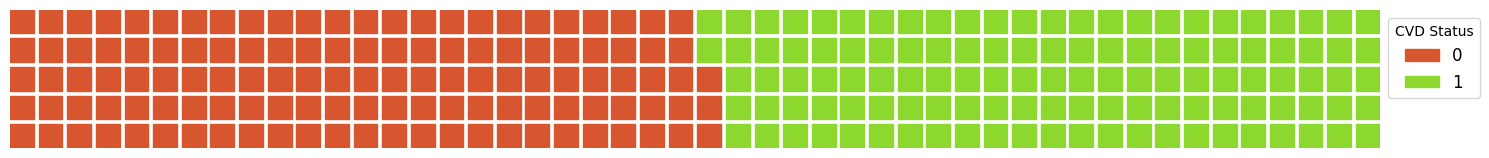

In [244]:
from pywaffle import Waffle

values = diag_cml_labeled_unique['has_cvd'].value_counts().to_dict()

fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=values,
    colors=["#d8562f", "#8cd82f"],
    block_arranging_style='snake',
    figsize=(15, 10),
    legend={
        'loc': 'upper left',
        'bbox_to_anchor': (1, 1),
        'fontsize': 12,
        'title': 'CVD Status'
    }
)


## Loading and Preprosessing Labevents data

In [245]:
lab = pd.read_csv(r'C:\Users\Yahya\Documents\GitHub\Internship\CSV_files\labevents_combined.csv')

In [246]:
diag_cml_lab = diag_cml_labeled.merge(lab, on=['subject_id', 'hadm_id'])

In [247]:
diag_cml_lab.head(25)

,subject_id,hadm_id,icd_code,icd_version,admittime,dischtime,has_cvd,duration_cvd,label,valuenum,valueuom,charttime
0,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN,"Potassium, Urine",27.000,mEq/L,2179-11-23 17:49:00
1,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN,"Potassium, Whole Blood",4.800,mEq/L,2179-11-22 19:43:00
2,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN,Anion Gap,12.000,mEq/L,2179-11-25 06:25:00
3,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN,Base Excess,-8.000,mEq/L,2179-11-23 04:41:00
4,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN,Base Excess,-10.000,mEq/L,2179-11-22 20:57:00
5,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN,Myelocytes,0.000,%,2179-11-23 15:20:00
6,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN,"Chloride, Whole Blood",111.000,mEq/L,2179-11-22 15:24:00
7,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN,"Hematocrit, Calculated",27.000,%,2179-11-22 15:24:00
8,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN,Epithelial Cells,0.000,#/hpf,2179-11-23 17:49:00
9,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN,Metamyelocytes,0.000,%,2179-11-23 15:20:00


## Loading and Preprosessing Pharmacy data

In [248]:
pharm = pd.read_csv(r'C:\Users\Yahya\Documents\GitHub\Internship\CSV_files\pharmacy_table.csv')

In [249]:
pharm.rename(columns={'duration':'duration_med'}, inplace=True)

In [250]:
pharm.drop(columns=['starttime', 'stoptime'])

,subject_id,hadm_id,medication,frequency,doses_per_24_hrs,duration_med,duration_interval
0,19044308,25510288,Hemorrhoidal Suppository,X1,1,NaN,Ongoing
1,19418856,24504521,Dextrose 50%,PRN,0,NaN,Ongoing
2,14675722,25409887,Dextrose 10% in Water (D10W),PRN,0,NaN,Ongoing
3,11875773,28656278,Heparin (Hemodialysis),Q1H,24,NaN,Ongoing
4,11925629,27177692,Lactulose,Q2H,12,NaN,Ongoing
...,...,...,...,...,...,...,...
8735104,18172623,28345295,Dexmedetomidine,TITRATE TO RASS,0,NaN,Ongoing
8735105,19732085,24560430,Propofol,TITRATE TO RASS,0,NaN,Ongoing
8735106,16266305,28784091,Propofol,TITRATE TO RASS,0,NaN,Ongoing
8735107,15012461,29116002,Propofol,TITRATE TO RASS,0,NaN,Ongoing


In [251]:
drug_mapping = {
    'imatinib': 'Imatinib',
    'imatinib mesylate': 'Imatinib',
    '*nf* imatinib mesylate': 'Imatinib',
    'imatinib oral suspension': 'Imatinib',
    'imatinib (gleevec)': 'Imatinib',
    'dasatinib': 'Dasatinib',
    'dasatinib 20mg tablet': 'Dasatinib',
    '*nf* dasatinib': 'Dasatinib',
    'ruxolitinib': 'Ruxolitinib',
    'inv-ruxolitinib': 'Ruxolitinib',
    'nilotinib': 'Nilotinib',
    '*nf* nilotinib': 'Nilotinib',
    'cabozantinib': 'Cabozantinib',
    'inv-cabozatinib': 'Cabozantinib',
    'ruxolitinib ':'Ruxolitinib',
    'inv-cabozantinib (cabozantinib)': 'Cabozantinib',
    'crizotinib': 'Crizotinib'
}

In [252]:
pharm['medication'] = pharm['medication'].str.lower().map(drug_mapping)


In [253]:
# Mark True if the normalized value is in the list of TKIs
tki_set = set(drug_mapping.values())

pharm['is_tki'] = pharm['medication'].isin(tki_set).astype(int)


In [254]:
pharm['is_tki'].value_counts()

0    8733956
1       1153
Name: is_tki, dtype: int64

In [263]:
pharm['medication'].value_counts(dropna=False)

NaN             8733956
Ruxolitinib         534
Imatinib            284
Dasatinib           209
Nilotinib            59
Cabozantinib         40
Crizotinib           27
Name: medication, dtype: int64

## Combine Labevents and Pharmacy data

In [260]:
diag_lab_pharm = diag_cml_lab.merge(pharm, on = ['subject_id', 'hadm_id'])
diag_lab_pharm = diag_lab_pharm.reset_index(drop=True)

In [261]:
diag_lab_pharm

,subject_id,hadm_id,icd_code,icd_version,admittime,dischtime,has_cvd,duration_cvd,label,valuenum,valueuom,charttime,medication,starttime,stoptime,frequency,doses_per_24_hrs,duration_med,duration_interval,is_tki
0,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN,"Potassium, Urine",27.0,mEq/L,2179-11-23 17:49:00,NaN,2179-11-25 22:00:00,2179-11-26 00:00:00,HS,1,NaN,Ongoing,0
1,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN,"Potassium, Urine",27.0,mEq/L,2179-11-23 17:49:00,NaN,2179-11-22 21:00:00,2179-11-23 14:00:00,Q4H,6,NaN,Ongoing,0
2,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN,"Potassium, Urine",27.0,mEq/L,2179-11-23 17:49:00,NaN,2179-11-23 08:00:00,2179-11-24 01:00:00,BID,2,NaN,Ongoing,0
3,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN,"Potassium, Urine",27.0,mEq/L,2179-11-23 17:49:00,NaN,2179-11-23 15:00:00,2179-11-26 00:00:00,Q6H,4,NaN,Ongoing,0
4,10147182,22852948,20510,9,2179-11-22 07:15:00,2179-11-25 19:47:00,0,NaN,"Potassium, Urine",27.0,mEq/L,2179-11-23 17:49:00,NaN,2179-11-24 07:00:00,2179-11-26 00:00:00,Q6H,4,NaN,Ongoing,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12626361,19912102,28143086,C9210,10,2185-08-16 01:21:00,2185-08-18 15:17:00,1,-58.541393,Sodium,144.0,mEq/L,2185-08-18 05:45:00,NaN,2185-08-16 04:00:00,2185-08-18 03:00:00,TID,3,2.0,Days,0
12626362,19912102,28143086,C9210,10,2185-08-16 01:21:00,2185-08-18 15:17:00,1,-58.541393,Sodium,144.0,mEq/L,2185-08-18 05:45:00,NaN,2185-08-16 04:00:00,2185-08-18 19:00:00,Q12H,2,NaN,Ongoing,0
12626363,19912102,28143086,C9210,10,2185-08-16 01:21:00,2185-08-18 15:17:00,1,-58.541393,Sodium,144.0,mEq/L,2185-08-18 05:45:00,NaN,2185-08-18 13:00:00,2185-08-18 19:00:00,Q12H,2,NaN,Ongoing,0
12626364,19912102,28143086,C9210,10,2185-08-16 01:21:00,2185-08-18 15:17:00,1,-58.541393,Sodium,144.0,mEq/L,2185-08-18 05:45:00,NaN,2185-08-16 08:00:00,2185-08-16 03:00:00,TID,3,NaN,Ongoing,0


In [265]:
diag_lab_pharm['medication'].value_counts(dropna=False)

NaN            12489865
Dasatinib         65064
Imatinib          55931
Nilotinib         15304
Ruxolitinib         202
Name: medication, dtype: int64

In [264]:
diag_lab_pharm['is_tki'].value_counts(dropna=False)

0    12489865
1      136501
Name: is_tki, dtype: int64